In [1]:
import os
import glob
import pickle
import numpy as np
import pandas as pd  
import csv
import string
from scipy.io import savemat
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from functools import reduce 
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import seaborn as sns
from scipy import stats
from scipy.stats import wasserstein_distance
from scipy.special import softmax
import scipy
import math
import random
import torch
from torch.nn import functional as F

In [44]:
os.chdir('/scratch/gpfs/arnab/sentence_encoding/')
e=loadmat('sentence_encoding.mat')
last_embedding=e['last_embedding'] ## each sentence word gets the embedding of the last word of that sentence
elec=np.squeeze(e['Y']) ## elec data for each word
last_word_index=e['index_last_word'] #last_word_index (1 if it is the last word, else 0)
word_number=np.squeeze(e['word_number']) #word number position for each sentence
sentence_number=np.squeeze(e['sentence_number']) #words belonging to which sentence
words=e['words'] #all words
all_emb=e['all_embedding'] ## all word embedding

Y_200=e['Y_200'] ##get neural 200ms data for each word

In [271]:
np.shape(elec)

(4813, 31)

In [214]:
np.shape(last_embedding)

(4813, 50)

In [89]:
indices=np.where(last_word_index==1)[1]
emb=last_embedding[indices,:]
Y=elec[indices,:]

np.shape(emb)
#np.shape(Y)

clf_linear=LinearRegression()
clf_linear.fit(emb,Y)
aa=clf_linear.predict(last_embedding)
# aa=clf_linear.predict(all_emb)

error=((elec-aa)**2).mean(axis=1)

np.shape(error)

(4813,)

In [217]:
np.shape(aa)

(4813, 31)

In [14]:
k=9
indices=np.where(sentence_number==k)[1]
err=pd.DataFrame()
err['error']=error[indices]
err['words']=words[indices]
print(err['error'].mean())
err

2991.6870385328207


,error,words
0,5449.083128,And
1,4739.006506,uh
2,4920.109070,you
3,5051.268076,know
4,4123.204013,I
5,3715.981757,know
6,2963.861339,a
7,2878.028407,little
8,2066.455514,bit
9,2574.450234,about


In [97]:
## making plot for t+1---t=5
t_0_index=(np.where(last_word_index==1)[-1])
t_1_index=(np.where(last_word_index==1)[-1])-1
t_2_index=(np.where(last_word_index==1)[-1])-2
t_3_index=(np.where(last_word_index==1)[-1])-3
t_4_index=(np.where(last_word_index==1)[-1])-4
t_5_index=(np.where(last_word_index==1)[-1])-5

t_0_ecog_pred=aa[t_0_index,:]
t_0_ecog_actual=elec[t_0_index,:]

t_1_ecog_pred=aa[t_1_index,:]
t_1_ecog_actual=elec[t_1_index,:]

t_2_ecog_pred=aa[t_2_index,:]
t_2_ecog_actual=elec[t_2_index,:]

t_3_ecog_pred=aa[t_3_index,:]
t_3_ecog_actual=elec[t_3_index,:]

t_4_ecog_pred=aa[t_4_index,:]
t_4_ecog_actual=elec[t_4_index,:]

t_5_ecog_pred=aa[t_5_index,:]
t_5_ecog_actual=elec[t_5_index,:]
q=[]
mse=[]
for k in range(np.shape(t_1_ecog_pred)[1]):
    q.append(np.corrcoef(t_1_ecog_pred[:,k],t_1_ecog_actual[:,k])[0,1])
    mse.append(np.mean((t_2_ecog_pred[:,k] - t_2_ecog_actual[:,k])**2/(t_0_ecog_pred[:,k] - t_0_ecog_actual[:,k])**2))

print(np.mean(q))
print(np.mean(mse))

0.21038114691258325
390088.94663177


In [91]:
mse[0]

16287.803023402383

In [85]:
k=0
np.mean((t_1_ecog_pred[:,k] - t_1_ecog_actual[:,k])**2/(t_0_ecog_pred[:,k] - t_0_ecog_actual[:,k])**2)

5098.216445383386

In [240]:
t_1_index[0:6]

array([ 15,  36,  50,  71, 106, 118])

In [236]:
indices[0:6]

array([ 16,  37,  51,  72, 107, 119])

In [310]:
## doing based on cv

indices=np.where(last_word_index==1)[1]


# np.shape(emb)
cv=4
kf = KFold(n_splits=cv)
p=0

for train_index, test_index in kf.split(indices):

        print('Fold:',p)
        # print(train_index[0])
        # print(train_index[-1])
        # print(test_index[0])
        # print(test_index[-1])

        emb_train=last_embedding[indices[train_index],:]
        Y_train=elec[indices[train_index],:]

        s=(sentence_number[indices[test_index]])
        ind=[]
        s1=[ind.extend(np.where(sentence_number==x)[0]) for x in s]

        emb_test=last_embedding[ind,:]
        Y_test=elec[ind,:]

        clf_linear=LinearRegression()
        clf_linear.fit(emb_train,Y_train)
        aa=clf_linear.predict(emb_test)

        print(np.shape(aa))

        ind2=[]
        s11=[ind2.extend(np.where(ind==x)[0]) for x in indices[test_index]]

        t_1_index=np.asarray(ind2)-1
        t_2_index=np.asarray(ind2)-2
        t_1_index=np.asarray(ind2)-3
        t_4_index=np.asarray(ind2)-4
        t_5_index=np.asarray(ind2)-5

        t_1_ecog_pred=aa[t_1_index,:]
        t_1_ecog_actual=Y_test[t_1_index,:]

        q=[]
        for k in range(np.shape(t_1_ecog_pred)[1]):
            q.append(np.corrcoef(t_1_ecog_pred[:,k],t_1_ecog_actual[:,k])[0,1])

        print(np.mean(q))

    
        
        
        p=p+1

# len(indices)

        

Fold: 0
(1155, 31)
-0.009579864286064325
Fold: 1
(1260, 31)
0.04498623203760825
Fold: 2
(1359, 31)
-0.0012717918350811754
Fold: 3
(1039, 31)
-0.03181986022315012


In [308]:
indices=np.where(last_word_index==1)[1]

cv=5
kf = KFold(n_splits=cv)
p=0

ind_good=[ 0,  3,  4,  8, 17, 19, 21]#[1,  3,  4,  5, 12, 15, 16, 26]#

for train_index, test_index in kf.split(indices):

        print('Fold:',p)
        # print(train_index[0])
        # print(train_index[-1])
        # print(test_index[0])
        # print(test_index[-1])

        s=(sentence_number[indices[train_index]])
        ind=[]
        s1=[ind.extend(np.where(sentence_number==x)[0]) for x in s]
        # break
        emb_train=all_emb[ind,:]
        Y_train=elec[ind,:]
        del s1
        del s
        s=(sentence_number[indices[test_index]])
        ind=[]
        s1=[ind.extend(np.where(sentence_number==x)[0]) for x in s]
        
        del s1
        del s

        emb_test=last_embedding[ind,:]
        Y_test=elec[ind,:]

        clf_linear=LinearRegression()
        clf_linear.fit(emb_train,Y_train)
        aa=clf_linear.predict(emb_test)

        print(np.shape(aa))

        ind2=[]
        s11=[ind2.extend(np.where(ind==x)[0]) for x in indices[test_index]]

        t_1_index=np.asarray(ind2)-1
        t_2_index=np.asarray(ind2)-2
        t_1_index=np.asarray(ind2)-3
        t_4_index=np.asarray(ind2)-4
        t_5_index=np.asarray(ind2)-5

        t_1_ecog_pred=aa[t_1_index,:]
        t_1_ecog_actual=Y_test[t_1_index,:]

        q=[]
        for k in range(np.shape(t_1_ecog_pred)[1]):
            q.append(np.corrcoef(t_1_ecog_pred[:,k],t_1_ecog_actual[:,k])[0,1])

        q=np.asarray(q)

        print(np.mean(q[ind_good]))

        # del q
        # break

    
        
        
        p=p+1



Fold: 0
(942, 31)
-0.030675004485347514
Fold: 1
(916, 31)
0.09200514476325386
Fold: 2
(1068, 31)
0.024660331910262366
Fold: 3
(1053, 31)
0.08594137435260236
Fold: 4
(834, 31)
0.15750897728892935


In [306]:
ww=np.where(np.asarray(q)>0.09)
q=np.asarray(q)

print(np.mean(q[ww]))

0.15750897728892935


In [307]:
ww


(array([ 0,  3,  4,  8, 17, 19, 21]),)

In [69]:
t_1_index

array([  9,  22,  34,  40,  56,  74,  87, 113, 135, 143, 162, 179, 186,
       200, 212, 222, 258, 276, 284, 316, 340, 351, 369, 388, 399, 413,
       420, 430, 445, 452, 462, 484, 493, 502, 510, 517, 530, 543, 559,
       570, 577, 585, 591, 606, 625, 639, 647, 665, 676, 691, 704, 717,
       723, 729, 744, 758, 764, 780, 794, 808, 824, 830])

## t_n for sliding window

In [203]:
def sliding_window_t_n(start, context,Y,word_embeddings,words):
    Y_train=Y[0:start,:]
    emb_train=word_embeddings[0:start,:]
    
    encoding_model = LinearRegression().fit(emb_train,Y_train)
    
    
    ##sentence prep
    sentence=[]
    for i in range(start+context,len(words)):
    # i=10
        a=words[i-context:i]
        
        s=[]
        s=(a[0].replace(" ", ""))
        for k in range(1,context):
            s=s+' '+(a[k].replace(" ", ""))
    
        sentence.append(s)

    # sliding_error=[]
    t_1_ecog_pred=[]
    t_1_ecog_actual=[]
    
    for k in range(start+context,len(words)):
        
        Y_test=Y[k-context :k,:]
        emb_test=np.tile(word_embeddings[k-1,:],(context,1))
        aa=encoding_model.predict(emb_test)
        error2=((Y_test-aa)**2)
        error=np.zeros((np.shape(error2)[0]-1,np.shape(error2)[1]))

        t_1_index=context-1
        t_2_index=context-2
        t_1_index=context-3
        t_4_index=context-4
        t_5_index=context-5
        
        t_1_ecog_pred.append(aa[t_1_index,:])
        t_1_ecog_actual.append(Y_test[t_1_index,:])

    t_1_ecog_pred=np.asarray(t_1_ecog_pred)
    t_1_ecog_actual=np.asarray(t_1_ecog_actual)
    q=[]
    for k in range(np.shape(t_1_ecog_pred)[1]):
        q.append(np.corrcoef(np.asarray(t_1_ecog_pred[:,k]),np.asarray(t_1_ecog_actual[:,k]))[0,1])

    # print(np.mean(q))
    
        
        
    # sentence    
    return t_1_ecog_pred,t_1_ecog_actual,sentence

In [17]:
start=4500
context=10
Y=elec.copy()
word_embeddings=all_emb.copy()

Y_train=Y[0:start,:]
emb_train=word_embeddings[0:start,:]

encoding_model = LinearRegression().fit(emb_train,Y_train)


# ##sentence prep
# sentence=[]
# for i in range(start+context,len(words)):
# # i=10
#     a=words[i-context:i]
    
#     s=[]
#     s=(a[0].replace(" ", ""))
#     for k in range(1,context):
#         s=s+' '+(a[k].replace(" ", ""))

#     sentence.append(s)

# sliding_error=[]
t_0_ecog_pred=[]
t_0_ecog_actual=[]
t_1_ecog_pred=[]
t_1_ecog_actual=[]

for k in range(start+context,len(words)):

    # print('k:',k)
    
    Y_test=Y[k-context :k,:]
    emb_test=np.tile(word_embeddings[k-1,:],(context,1))
    aa=encoding_model.predict(emb_test)
    error2=((Y_test-aa)**2).mean(axis=1)
    error2=error2/error2[-1]
    break
    error=np.zeros((np.shape(error2)[0]-1,np.shape(error2)[1]))

    t_1_index=context-1
    t_2_index=context-2
    t_3_index=context-3
    t_4_index=context-4
    t_5_index=context-5

    t_0_ecog_pred.append(aa[t_1_index,:])
    t_0_ecog_actual.append(Y_test[t_1_index,:])

    t_1_ecog_pred.append(aa[t_1_index-1,:])
    t_1_ecog_actual.append(Y_test[t_1_index-1,:])

    # print(Y_test[t_1_index-1,0])

    # break
t_0_pred=np.asarray(t_0_ecog_pred)
t_0_actual=np.asarray(t_0_ecog_actual)


q1=np.asarray(t_1_ecog_pred)
q2=np.asarray(t_1_ecog_actual)
q=[]
mse=[]
for k in range(np.shape(t_1_ecog_pred)[1]):
    q.append(np.corrcoef(q1[:,k],q2[:,k])[0,1])
    mse.append(np.mean((q1[:,k] - q2[:,k])**2/(t_0_pred[:,k] - t_0_actual[:,k])**2))

# print(np.mean(q))
ind3=[ 2,  4,  9, 10, 13, 14, 19, 21, 22, 23, 24, 26, 27]
# q=np.asarray(q)
# q[ind3].mean()
mse=np.asarray(mse)
print(np.mean(mse[ind3]))

IndexError: tuple index out of range

In [53]:
start=4500
context=10
Y=elec.copy()
word_embeddings=all_emb.copy()
ind3=[ 2,  4,  9, 10, 13, 14, 19, 21, 22, 23, 24, 26, 27]
Y_train=Y[0:start,ind3]
emb_train=word_embeddings[0:start,:]

encoding_model = LinearRegression().fit(emb_train,Y_train)


# ##sentence prep
# sentence=[]
# for i in range(start+context,len(words)):
# # i=10
#     a=words[i-context:i]
    
#     s=[]
#     s=(a[0].replace(" ", ""))
#     for k in range(1,context):
#         s=s+' '+(a[k].replace(" ", ""))

#     sentence.append(s)

# sliding_error=[]
t_0_ecog_pred=[]
t_0_ecog_actual=[]
t_1_ecog_pred=[]
t_1_ecog_actual=[]
t_1_mse=[]
for k in range(start+context,len(words)):

    # print('k:',k)
    
    Y_test=Y[k-context :k,ind3]
    emb_test=np.tile(word_embeddings[k-1,:],(context,1))
    aa=encoding_model.predict(emb_test)
    error2=((Y_test-aa)**2).mean(axis=1)
    # error2=error2[:,ind3].mean(axis=1)
    error2=error2/error2[-1]

    t_1_mse.append(error2[-6])
   
#     error=np.zeros((np.shape(error2)[0]-1,np.shape(error2)[1]))

#     t_1_index=context-1
#     t_2_index=context-2
#     t_3_index=context-3
#     t_4_index=context-4
#     t_5_index=context-5

#     t_0_ecog_pred.append(aa[t_1_index,:])
#     t_0_ecog_actual.append(Y_test[t_1_index,:])

#     t_1_ecog_pred.append(aa[t_1_index-1,:])
#     t_1_ecog_actual.append(Y_test[t_1_index-1,:])

#     # print(Y_test[t_1_index-1,0])

#     # break
# t_0_pred=np.asarray(t_0_ecog_pred)
# t_0_actual=np.asarray(t_0_ecog_actual)


# q1=np.asarray(t_1_ecog_pred)
# q2=np.asarray(t_1_ecog_actual)
# q=[]
# mse=[]
# for k in range(np.shape(t_1_ecog_pred)[1]):
#     q.append(np.corrcoef(q1[:,k],q2[:,k])[0,1])
#     mse.append(np.mean((q1[:,k] - q2[:,k])**2/(t_0_pred[:,k] - t_0_actual[:,k])**2))

# # print(np.mean(q))
# ind3=[ 2,  4,  9, 10, 13, 14, 19, 21, 22, 23, 24, 26, 27]
# # q=np.asarray(q)
# # q[ind3].mean()
# mse=np.asarray(mse)
# print(np.mean(mse[ind3]))
print(np.mean(t_1_mse))
print(scipy.stats.sem(t_1_mse))

1.654818412587575
0.09522634372515858


In [10]:
error2

array([0.60858178, 1.32738813, 1.72679483, 2.0087849 , 2.9287475 ,
       1.09975533, 2.3417012 , 2.27493147, 1.6711622 , 1.        ])

In [196]:
aa[:,0]

array([21.04932863, 21.04932863, 21.04932863, 21.04932863, 21.04932863,
       21.04932863, 21.04932863, 21.04932863, 21.04932863, 21.04932863])

In [177]:
q1[:,30][0:5]

array([12.51355943, -2.6335965 , 19.14752435, 33.07974648, 21.53771623])

In [178]:
q2[:,30][0:5]

array([ 49.91006489, -20.56917075,  51.90745009,   0.52660304,
        21.33828603])

In [217]:
q=[]
for k in range(np.shape(t_1_ecog_pred)[1]):
    q.append(np.corrcoef(q1[:,k],q2[:,k])[0,1])


In [260]:
q=np.asarray(q)
ind3=np.where(np.asarray(q)<0.05)[-1]
q[ind3]

array([ 0.0489013 ,  0.03590178,  0.01625713, -0.0423999 ,  0.04407187,
        0.01048927, -0.12226159, -0.06479422, -0.01221135, -0.00259751,
       -0.01118947,  0.03097836,  0.01055946, -0.09153729])

In [261]:
ind3

array([ 0,  1,  3,  5,  6,  7,  8, 15, 16, 17, 25, 28, 29, 30])

In [249]:
df_all_sub=pd.read_csv('/scratch/gpfs/arnab/Encoding/all_subject_sig_with_area.csv')

In [266]:
df2=df_all_sub.loc[df_all_sub.subject==717]
np.asarray(df2.area.values)[ind3]

array(['IFG', 'IFG', 'parietal', 'STG', 'STG', 'STG', 'IFG', 'STG', 'STG',
       'STG', 'IFG', 'IFG', 'IFG', 'IFG'], dtype=object)

In [181]:
start=4000
context=10
q1,q2,s=sliding_window_t_n(start, context,elec,all_emb,words)

In [151]:
q1[:,30][0:5]

array([12.51355943, -2.6335965 , 19.14752435, 33.07974648, 21.53771623])

In [152]:
q2[:,30][0:5]

array([ 67.5567894 ,  49.91006489, -20.56917075,  51.90745009,
         0.52660304])

In [153]:
np.corrcoef(q1[:,30],q2[:,30])

array([[ 1.        , -0.01503521],
       [-0.01503521,  1.        ]])

In [202]:
emb_train=all_emb[0:start,:]
emb_test=all_emb[start:,:]

Y_train=elec[0:start,:]
Y_test=elec[start:,:]
encoding_model = LinearRegression().fit(emb_train,Y_train)
aa=encoding_model.predict(emb_test)

In [203]:
np.corrcoef(aa[:,30],Y_test[:,30])

array([[1.        , 0.25464553],
       [0.25464553, 1.        ]])

In [204]:
aa[:,0][0:10]

array([18.10610042, 21.44579815, 18.69911574, 15.37057247, 16.85890386,
        6.77435287, 22.21928288, 20.88096227, 15.90153537, 21.04932863])

In [205]:
Y_test[:,0][0:10]

array([-37.9342005 ,  -3.22200296,  48.78416239, -60.71188173,
       -53.21687497,  72.13232228, 169.45280849, 138.68213774,
       -30.70565381, -45.34518779])

## word number based

In [36]:
k=5
indices=np.where(word_number==k)
emb=np.squeeze(all_emb[indices,:])
Y=np.squeeze(elec[indices,:])

clf_linear=LinearRegression()
clf_linear.fit(emb,Y)

np.shape(emb)

(314, 50)

In [134]:
max(np.unique(word_number))

55

In [16]:
a1=[]
a2=[]
a3=[]
p=0
for k in range(1,40):
    
    indices=np.where(word_number==k)
    emb=np.squeeze(all_emb[indices,:])
    Y=np.squeeze(elec[indices,:])

    clf_linear=LinearRegression()
    clf_linear.fit(emb,Y)

    for j in range(len(np.unique(sentence_number))):

        index2=np.where(sentence_number==j)[1]
        s=word_number[index2]
        if k in s:
            emb2=all_emb[index2,:] # if we are using original embeddings
            
            # if we are using the words embeddings
#             ind=np.squeeze(np.intersect1d(np.where(sentence_number==1)[1], np.squeeze(np.where(word_number==2))))
#             emb22=all_emb[ind,:]
#             emb2=np.repeat(emb22[np.newaxis,...], len(index2),axis=0)
            
            
            Y2=elec[index2,:]
            aa=clf_linear.predict(emb2)
            error=((Y2-aa)**2).mean(axis=1)
            if p==0:
                a1.append([error])
                
            else:
                a1[j].append([error])
#             a2[j].append(j)
#             a3[j].append(k)
            
            del error 
    p=1

error_mat=[]
for i in range(len(a1)):
    
    q=np.zeros((len(a1[i]),len(a1[i][0])))
    
    for k1 in range(len(a1[i])):
                #=(a1[i][k1])
                q[k1,:]=np.asarray(a1[i][k1])
                
    error_mat.append(q)
                    
    del q 

In [22]:
(error_mat[1][0])

array([ 1676.46022766, 31367.05459017, 26287.87282154, 61986.78690648,
       42361.14531909, 42809.75231875, 53156.44428139, 23557.97879341,
       17456.11115036, 19660.54245049, 11370.85666062, 40039.30039446,
       21819.38371039, 19163.1556629 , 33752.67785654, 17288.15669853,
       20765.34719978, 28118.16795953,  8560.71083597, 34787.67242387,
       30800.440689  ])

## word wise correlation

In [3]:
np.shape(Y_200)

(314, 31, 55, 103)

In [4]:
corr_mat=[]
for i in range(len(np.unique(sentence_number))):
    
    l=len(np.where(sentence_number==i)[1])
    
    
    for j in range(np.shape(Y_200)[1]):
        
        Y=Y_200[i,j,0:l,:]
        
        if j==0:
            mat=np.corrcoef(Y)
        else:
            mat=mat+np.corrcoef(Y)
            
    mat=mat/np.shape(Y_200)[1]
    
    corr_mat.append(mat)
    
        
            
            
            
            

In [5]:
filename='corr_score_each_sentence_podcast.mat'

savemat(filename,{'corr_mat':corr_mat})

/home/arnab/.conda/envs/srm_arnab/lib/python3.9/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [29]:
np.shape(corr_mat[313][0])

(6,)

In [14]:
len(np.where(sentence_number==0)[1])


17

In [24]:
len(np.unique(sentence_number))

314

In [20]:
np.shape(Y)

(6, 103)

## Attention Mask

In [4]:
df_sentence=pd.read_csv('all_sentence_podcast.csv')
sentences=df_sentence['sentence']
num_word=df_sentence['num_word']
cumulative_words=np.cumsum(num_word)

In [5]:
s=sentences[0]
s

"So there's some places where animals almost never go, places that are designed by humans for humans."

In [6]:
s[5:-1]

"ere's some places where animals almost never go, places that are designed by humans for humans"

In [62]:
size=40

sentence=[]
for k in range(10): #range(len(sentences)):
    s=sentences[k]
    sentence.append(s)
    
    
    
#     print(sentence)
    
    
    if len(str(sentence).split())>size:
        
        print(len(str(sentence).split()))
        
        s1=[]
        s1.append(sentence[0][len(str(sentence).split())-size:-1])
        sentence=[]
        sentence.append(s1)
    
#     a=remove_punc(sentence[0])
#     sentence=[]
#     sentence.append(a)
    print(sentence)
    

["So there's some places where animals almost never go, places that are designed by humans for humans."]
["So there's some places where animals almost never go, places that are designed by humans for humans.", 'This act ends up in a place like that, but it starts about as far from there as you can get.']
52
[['ome places where animals almost never go, places that are designed by humans for humans']]
[['ome places where animals almost never go, places that are designed by humans for humans'], 'A few years ago, the photographer David Slater traveled there from his home in England to photograph a troop of monkeys.']
71
[[[]]]
[[[]], 'you name it, I had to I had to go through it.']
[[[]], 'you name it, I had to I had to go through it.', 'Uh and it was just so amazing just to be to be like a monkey.']
[[[]], 'you name it, I had to I had to go through it.', 'Uh and it was just so amazing just to be to be like a monkey.', 'I I I was a monkey honestly.']
49
[[[]]]
[[[]], 'And uh you know I kno

In [53]:
print(sentence)


[[[]], 'And uh you know I know a little bit about monkey monkey etiquette and showing your teeth not to show your teeth, not to stare them in the face.']


In [59]:
def remove_punc(s):
    punc = '''!()-[]{};:"\,<>./?@#$%^&*_~'''
    s=str(s)
    for ele in s:
        if ele in punc:
           
            s = s.replace(ele, "")

    return s

In [38]:
size=10
sentence[0][5:-1]

"ere's some places where animals almost never go, places that are designed by humans for humans"

In [49]:
# initializing string
test_str = "Gfg, is best : for ! Geeks ;"
 
# printing original string
print("The original string is : " + test_str)
 
# initializing punctuations string
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
 
# Removing punctuations in string
# Using loop + punctuation string
for ele in test_str:
    if ele in punc:
        test_str = test_str.replace(ele, "")
 
# printing result
print("The string after punctuation filter : " + test_str)

The original string is : Gfg, is best : for ! Geeks ;
The string after punctuation filter : Gfg is best  for  Geeks 


In [28]:
len(str(sentence).split())

17

## Analysis

In [2]:
def load_pickle(file_path):
    
    pickle_file = open(file_path, "rb")
    objects = []

    i=0

    while True:
        print('i',i)
        try:

            objects.append(pickle.load(pickle_file))

        except EOFError:

            break

    pickle_file.close()

    a=objects[0]
    
    return a

In [3]:
def load_label(filepath):

    with open(filepath, "rb") as f:
        full_labels = pickle.load(f)
        #labels_df = pd.DataFrame(full_labels["labels"])
        labels_df = pd.DataFrame(full_labels)

    # labels_df["audio_onset"] = ((labels_df.onset + 3000) / 512)
    # labels_df["audio_offset"] = ((labels_df.offset + 3000) / 512)

    # labels_df = labels_df.dropna(subset=["audio_onset", "audio_offset"])
    

    return labels_df

In [7]:
pickle_file_path='attention.pickle'
df=load_pickle(pickle_file_path)
df.keys()

i 0
i 0


dict_keys(['attention_mask', 'sentence_words', 'token_idx'])

In [55]:
attn=df['attention_mask']
sentence_words=df['sentence_words']
idx=df['token_idx']

mse=loadmat('mse_score_each_sentence_podcast.mat')['error_mat']

In [75]:
mse_score=[]
corr_score=[]

for sentence in range(len(attn)):
    a1=attn[sentence].detach().numpy()
    w1=sentence_words[sentence]
    id=idx[sentence]

    indices=np.where(id==0)[0]
    a1=np.delete(a1,indices, axis=0)
    a1= np.delete(a1,indices, axis=1)

    c1=corr_mat[sentence]

    for i in range(np.shape(a1)[0]):
        a1[i,i+1:]=-np.inf

    x1 = F.softmax(torch.from_numpy(a1), dim = 1)  ##attention mask
    
    for i in range(np.shape(c1)[0]):
        c1[i,i:]=-np.inf
    
    x2 = F.softmax(torch.from_numpy(c1), dim = 1)  ## ecog corr

    x3=mse[0][sentence]

    mse_score1=[]
    corr_score1=[]
    for k in range(2,min(np.shape(a1)[0],35)):

        attn_input=x1[k-2,:k-1]
        corr_input=x2[k-1,:k-1]
        mse_input=x3[k-1,:k-1]

        mse_score1.append(stats.spearmanr(attn_input, mse_input).statistic)
        corr_score1.append(stats.spearmanr(attn_input, corr_input).statistic)
    
    mse_score1 = [x for x in mse_score1 if (math.isnan(x) != True)]
    corr_score1 = [x for x in corr_score1 if (math.isnan(x) != True)]
    mse_score.append(np.mean(mse_score1))
    corr_score.append(np.mean(corr_score1))

    

        
    

    

    



(array([ 4.,  5., 12., 23., 55., 76., 63., 40., 20., 16.]),
 array([-0.76666667, -0.59666667, -0.42666667, -0.25666667, -0.08666667,
         0.08333333,  0.25333333,  0.42333333,  0.59333333,  0.76333333,
         0.93333333]),
 <BarContainer object of 10 artists>)

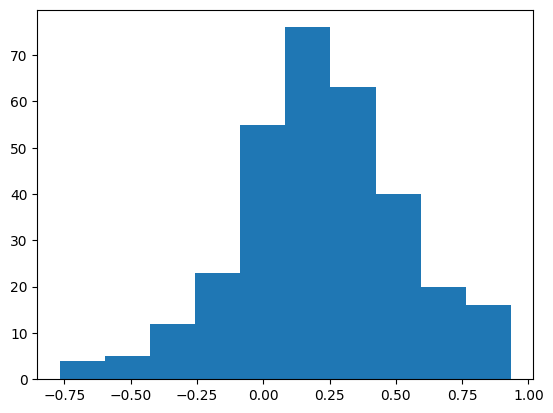

In [76]:
plt.hist(mse_score)

(array([  2.,   7.,   7.,  46., 130.,  85.,  24.,  10.,   1.,   2.]),
 array([-0.83333333, -0.65666667, -0.48      , -0.30333333, -0.12666667,
         0.05      ,  0.22666667,  0.40333333,  0.58      ,  0.75666667,
         0.93333333]),
 <BarContainer object of 10 artists>)

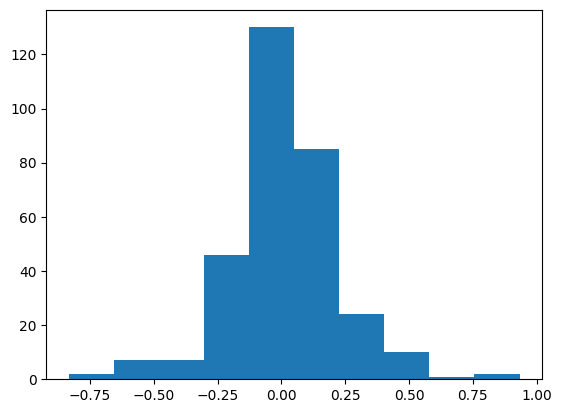

In [77]:
plt.hist(corr_score)

In [2]:
###

# 1) test with last word embedding
# 2) concatenate the last word mse scores for each sentence to make it a big vector, Do the same for attn mask. Measure correlation 
# 3) see attn mask for last layer, all heads

In [9]:
indices=np.where(id==0)[0]
a1=np.delete(a1,indices, axis=0)
a1= np.delete(a1,indices, axis=1)

np.shape(a1)

(17, 17)

In [10]:
w1

[' So',
 ' there',
 "'s",
 ' some',
 ' places',
 ' where',
 ' animals',
 ' almost',
 ' never',
 ' go',
 ',',
 ' places',
 ' that',
 ' are',
 ' designed',
 ' by',
 ' humans',
 ' for',
 ' humans',
 '.']

In [11]:
c1=corr_mat[0]
np.shape(c1)

(17, 17)

In [12]:
a1=attn[0].detach().numpy()
for i in range(np.shape(a1)[0]):
    a1[i,i+1:]=-np.inf

x1 = F.softmax(torch.from_numpy(a1), dim = 1)

for i in range(np.shape(c1)[0]):
    c1[i,i:]=-np.inf

x2 = F.softmax(torch.from_numpy(c1), dim = 1)


In [30]:
k=7
input=x1[k-2,:k-1]

In [31]:
k=7
target=x2[k-1,:k-1]

In [18]:
loss = torch.nn.CrossEntropyLoss()
output = loss(input, target)

In [19]:
output

tensor(1.3930, dtype=torch.float64)

In [32]:

res = stats.spearmanr(input, target).statistic
res

0.028571428571428574

In [26]:
res

-1.0

In [33]:
target

tensor([0.1579, 0.1642, 0.1711, 0.1764, 0.1471, 0.1833], dtype=torch.float64)

In [34]:
input

tensor([0.2906, 0.1385, 0.1421, 0.1388, 0.1401, 0.1499])

In [39]:
mse=loadmat('mse_score_each_sentence_podcast.mat')['error_mat']

In [53]:
x3=mse[0][1]
k=10
input=x1[k-2,:k-1]
target=x3[k-1,:k-1]

res = stats.spearmanr(input, target).statistic
res

-0.21666666666666667

In [48]:
target

array([3304.47658116, 3932.88283523, 6227.17631449, 1541.30233892,
       3235.12558752, 2363.03427911])

In [49]:
input

tensor([0.2906, 0.1385, 0.1421, 0.1388, 0.1401, 0.1499])

21

## loading embeddings for different context length

In [2]:
def load_word():
    path_ken1="/scratch/gpfs/arnab/sentence_encoding/embeddings/"
    model_size='gpt2-xl'
    path_ken=path_ken1+model_size+'/full/'
    os.chdir(path_ken)
    
    pickle_file = open("base_df.pkl", "rb")
    objects = []
    
    i=0
    
    while True:
        # print('i',i)
        try:
    
            objects.append(pickle.load(pickle_file))
    
        except EOFError:
    
            break
    
    pickle_file.close()
    
    a=objects[0]
    df=pd.DataFrame(a)
    df2=df.loc[~df.adjusted_onset.isnull() & (df.token_idx==0)] # and df.token_idx==1
    index=df2.index
    
    onsets=np.squeeze(df2.adjusted_onset.values)
    words=df2.word.values

    return onsets, words, index

In [3]:
def load_embeddings(index, context, layer):
    path_ken1="/scratch/gpfs/arnab/247-pickling/results/podcast/661/embeddings/"
    model_size='gpt2-xl'
    path_ken=path_ken1+model_size+'/full/'
    context_path='cnxt_00'+str(context).zfill(2)+'/layer_'+str(layer).zfill(2)+'/'
    emb_file='NY661_111_Part1_conversation1.pkl'
    
    path_emb=path_ken+context_path+emb_file
    # os.chdir(path_emb)
    
    # emb_file='layer_48.pkl'
    
    
    pickle_file = open(path_emb, "rb")
    objects = []
    
    i=0
    
    while True:
        # print('i',i)
        try:
    
            objects.append(pickle.load(pickle_file))
    
        except EOFError:
    
            break
    
    pickle_file.close()
    
    a=objects[0]
    
    df_emb=pd.DataFrame(a)
    df_bert=df_emb.iloc[index]
    w=(df_bert.embeddings.values)
    # type(w[0])
    # np.shape(w)
    emb=np.zeros((len(w),np.shape(w[0])[0]))
    for i in range(len(w)):
        emb[i,:]=w[i]
        
    # print(np.shape(emb))
    
    pca = PCA(n_components=50)
    emb=emb- np.mean(emb, axis=0)
    word_embeddings=pca.fit_transform(emb)

    return  word_embeddings

# path="/scratch/gpfs/arnab/Encoding/different_size/"
# os.chdir(path)
# filename=model_size+'.mat'
# savemat(filename,{'onset':onset,'embeddings':emb})
# del emb

## loading ecog

In [4]:
def load_ecog(onsets):

    path='/scratch/gpfs/arnab/Encoding/'
    os.chdir(path)
    df_all_sub=pd.read_csv('all_subject_sig.csv')
    # subjects=np.unique(df_all_sub['subject'])
    subjects=[717]
    lags=[0]
    shift_ms=300 # this is a dummy parameter, not used
    cv=10
    
    electrodes1=[]
    elec_num=[]
    for qq in range(len(subjects)):
        
        subject=subjects[qq]
        #print('subject:',subject)
        s=np.array(df_all_sub.loc[df_all_sub.subject==subject].matfile)
        electrodes1.append(s)
        elec_num.append(len(s))
    
    Y_data= np.zeros((len(subjects),len(lags),len(onsets),max(elec_num))) #45 is the electrode number here
    
    for qq in range(len(subjects)):
        
        subject=subjects[qq]
        print('subject:',subject)
        
        electrodes=electrodes1[qq]
        # elec_num.append(len(electrodes))
        
        if qq==0:
            path=os.path.join(os.pardir,'significant_electrode_podcast',str(subject))
        else:
            path=os.path.join(os.pardir,str(subject))
    
        os.chdir(path)
        
        ecogs=[]
        for i in electrodes:
            filename='NY'+str(subject)+'_111_Part1_conversation1_electrode_preprocess_file_'+str(i)+'.mat'
            
            e=loadmat(filename)['p1st'].squeeze().astype(np.float32)
            ecogs.append(e)
            
        ecogs = np.asarray(ecogs).T
    
        window_size=200
    
        half_window = round((window_size / 1000) * 512 / 2)
        #t = len(brain_signal)
        t=len(ecogs[:,0])
     
        Y= np.zeros((len(onsets), np.shape(ecogs)[1]))
        
            
        for ii in range(len(lags)):
            Y1 = np.zeros((len(onsets), 2 * half_window + 1))
            #print(ii)
            for k in range(np.shape(ecogs)[1]):
        
                brain_signal=ecogs[:,k]
                #from numba import jit, prange
                
                # for lag in prange(len(lags)):
                
                lag_amount = int(lags[ii]/ 1000 * 512)
                
                index_onsets = np.minimum(
                    t - half_window - 1,
                    np.maximum(half_window + 1,
                                np.round(onsets, 0, onsets) + lag_amount))
                
                # subtracting 1 from starts to account for 0-indexing
                starts = index_onsets - half_window - 1
                stops = index_onsets + half_window
                
                for i, (start, stop) in enumerate(zip(starts, stops)):
                    start=int(start)
                    stop=int(stop)
                    Y1[i, :] = brain_signal[start:stop].reshape(-1)
                    
                                    
                #if subject==717:
                   
                Y_data[qq,ii,:,k] = np.mean(Y1, axis=-1)
                # if subject==742:
                #     Y_742[ii,:,k] = np.mean(Y1, axis=-1)
                # if subject==798:
                #     Y_798[ii,:,k] = np.mean(Y1, axis=-1)
    
    Y=Y_data[0,0,:,:]
    return Y

## sliding window

In [5]:
# start=4000
# context=10

def sliding_window(start, context,Y,word_embeddings,words):
    Y_train=Y[0:start,:]
    emb_train=word_embeddings[0:start,:]
    
    encoding_model = LinearRegression().fit(emb_train,Y_train)
    
    
    # sentence prep
    sentence=[]
    for i in range(start+context,len(words)):
    # i=10
        a=words[i-context:i]
        
        s=[]
        s=(a[0].replace(" ", ""))
        for k in range(1,context):
            s=s+' '+(a[k].replace(" ", ""))
    
        sentence.append(s)

    sliding_error=[]
    original_error=[]
    corr=[]
    
    for k in range(start+context,len(words)):
        
        Y_test=Y[k-context :k,:]
        emb_test=np.tile(word_embeddings[k-1,:],(context,1))
        aa=encoding_model.predict(emb_test)
        error2=((Y_test-aa)**2)
        error=np.zeros((np.shape(error2)[0]-1,np.shape(error2)[1]))
        
        for q in range(np.shape(error2)[1]):
            x=1/(error2[:,q]/error2[context-1,q])
            ind=np.where(x>5)
            x[ind]=5 ## chenge this parameter
            error[:,q]=softmax(x[:-1])

        a=[]
        for kk in range(np.shape(error2)[0]):

            a.append(np.corrcoef(aa[kk,:],Y_test[kk,:])[0,1])

        corr.append(np.asarray(a))
        sliding_error.append(error)
        original_error.append(error2)
        
    # sentence    
    return sentence, sliding_error, original_error,corr

In [14]:
np.shape(word_embeddings)

NameError: name 'word_embeddings' is not defined

In [15]:
def sliding_error(encoding_model,Y,word_embeddings,context,words):
    
    sliding_error=[]
    for k in range(start+context,len(words)):
        
        Y_test=Y[k-context :k,:]
        emb_test=np.tile(word_embeddings[k-1,:],(context,1))
        aa=encoding_model.predict(emb_test)
        error2=((Y_test-aa)**2)
        error=np.zeros((np.shape(error2)[0]-1,np.shape(error2)[1]))
        
        for q in range(np.shape(error2)[1]):
            x=1/(error2[:,q]/error2[context-1,q])
            ind=np.where(x>5)
            x[ind]=5 ## chenge this parameter
            error[:,q]=softmax(x[:-1])
    
        
        sliding_error.append(error)
        # np.shape(error)

    return sliding_error

In [10]:
len(sliding_error)

987

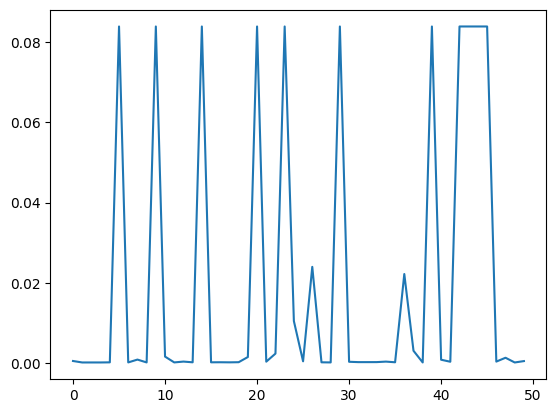

In [18]:
plt.plot(error[:,20])


## Analysis with sliding window

In [6]:
def load_pickle(file_path):
    
    pickle_file = open(file_path, "rb")
    objects = []

    i=0

    while True:
        # print('i',i)
        try:

            objects.append(pickle.load(pickle_file))

        except EOFError:

            break

    pickle_file.close()

    a=objects[0]
    
    return a

def load_label(filepath):

    with open(filepath, "rb") as f:
        full_labels = pickle.load(f)
        #labels_df = pd.DataFrame(full_labels["labels"])
        labels_df = pd.DataFrame(full_labels)

    # labels_df["audio_onset"] = ((labels_df.onset + 3000) / 512)
    # labels_df["audio_offset"] = ((labels_df.offset + 3000) / 512)

    # labels_df = labels_df.dropna(subset=["audio_onset", "audio_offset"])
    

    return labels_df

def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [13]:
# df_head=pd.DataFrame()
contexts=[10]
layers=[2]#list(range(1,48,1))
heads=[16]#,21,23]#np.arange(1,2)

###for layer 2 heads=[1,9,16,21,23]
#### for layer 48, heads [1,3,4,10,14,22,]

start=4000
k=0
# loss = torch.nn.CrossEntropyLoss()
onsets, words, index=load_word()
Y=load_ecog(onsets)

for layer in layers:
    print('layer:',layer)
    for context in contexts: 
        
        word_embeddings=load_embeddings(index, context, layer)
        
        sentence,sliding_error,original_error,corr=sliding_window(start, context,Y,word_embeddings,words)

        print('context:',context)
        
        a1=[]
        a2=[]

        # head_kl1=[]
        # head_cross_entropy1=[]

        
        for head in heads:
            name='attention_gpt2-xl_layer_'+str(layer)+'_head_'+str(head)+'_context_'+str(context)+'.pkl'
            
            pickle_file_path='/scratch/gpfs/arnab/sentence_encoding/results/gpt2-xl/layer_'+str(layer)+'/context_'+str(context)+'/'+name
            df_attn=load_pickle(pickle_file_path)
            attn=df_attn['attention_mask']
            
            spearman_corr_score=[]
            pearson_corr_score=[]
            output=[]
            kl=[]
            wassertain=[]
            
            
            elec=36
            
            for sentence in range(len(attn)):
                x1=attn[sentence] ##attention mask
                # x1=softmax(x1)
                x1=x1/np.sum(x1)

            
                a1.extend(x1)
                
                x2 = sliding_error[sentence].mean(axis=1)  ##average of all the electrodes  
                # x2 = sliding_error[sentence][:,elec]  ##selected electrode
            
                a2.extend(x2)
                
                # spearman_corr_score.append(stats.spearmanr(x1, x2).statistic)    
                # pearson_corr_score.append(np.corrcoef(x1,x2)[0,1])
                # output.append(loss(torch.from_numpy(x1), torch.from_numpy(x2)))
                # output.append(loss(torch.from_numpy(x1), torch.from_numpy(x2)))
                kl.append(kl_divergence(x1,x2))
                # wassertain.append(wasserstein_distance(x1,x2))

            
        
        
            
        # print(np.mean(pearson_corr_score))
        # print(np.mean(spearman_corr_score))
        
            
            # print(np.corrcoef(a1,a2)[0,1])
            # print(stats.spearmanr(a1, a2).statistic)
            # head_cross_entropy1.append(np.mean(output))  
            # # print(np.std(output))  
            # head_kl1.append(np.mean(kl))
        
            # df_head.loc[k,'layer']=layer
            # df_head.loc[k,'head_kl']=np.mean(kl)
            # # df_head.loc[k,'cross_entropy']=np.mean(output)
            # df_head.loc[k,'context']=context
            # # df_head.loc[k,'wassertain']=np.mean(wassertain)
            # k=k+1
            



subject: 717
layer: 2
context: 10


In [ ]:
df_head

In [45]:
df_head['family']=df_head.layer.values

In [46]:
df_head

,layer,head_kl,cross_entropy,context,wassertain,family
0,1.0,0.253319,2.200437,10.0,0.038181,1.0
1,1.0,0.168532,2.199252,10.0,0.028602,1.0
2,1.0,0.397507,2.202876,10.0,0.059443,1.0
3,1.0,0.594323,2.210626,10.0,0.083216,1.0
4,1.0,0.422119,2.205095,10.0,0.063432,1.0
...,...,...,...,...,...,...
495,10.0,1.676374,3.895682,50.0,0.021679,10.0
496,10.0,2.087678,3.896862,50.0,0.025939,10.0
497,10.0,1.464871,3.895218,50.0,0.019440,10.0
498,10.0,1.780691,3.894786,50.0,0.024326,10.0


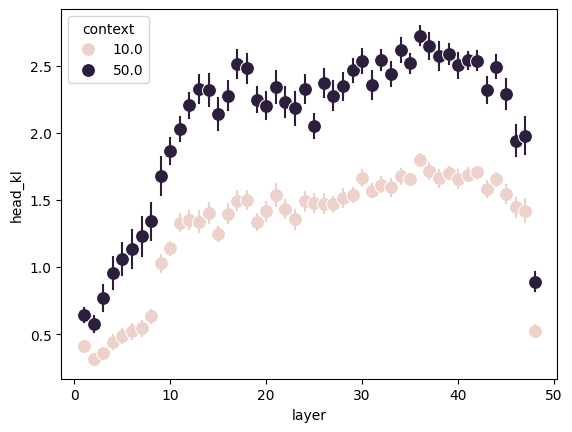

In [308]:
snsplt = sns.lineplot(
    data=df_head, #loc[df_head.context==10],
    x="layer",
    y="head_kl",
    hue="context",
    marker="o",
    markersize=10,
    # alpha = 0.5,
    
    linestyle='',
    err_style='bars',
    errorbar="se",)
    # hue_order=["gpt2","llama2","opt","gpt-neo","llama2-q","opt-q"]
    # hue_order=["gpt2","llama2-q","opt-q","gpt-neo"]

# snsplt = sns.lineplot(
#     data=df_head.loc[df_head.context==50],
#     x="layer",
#     y="head_kl",
#     hue="family",
#     marker="",
#     markersize=10,
#     # alpha = 0.5,
#     linestyle='',
#     err_style='bars',
#     errorbar="se",)
#     # hue_order=["gpt2","llama2","opt","gpt-neo","llama2-q","opt-q"]
#     # hue_order=["gpt2","llama2-q","opt-q","gpt-neo"]
# fig = snsplt.get_figure()
# fig.savefig("/scratch/gpfs/arnab/sentence_encoding/out.png",dpi=600) 

In [78]:
df_head=pd.read_csv('layers_1_10_context_10_50.csv')

21
PearsonRResult(statistic=0.36435096446476045, pvalue=0.10441649075662839)
21


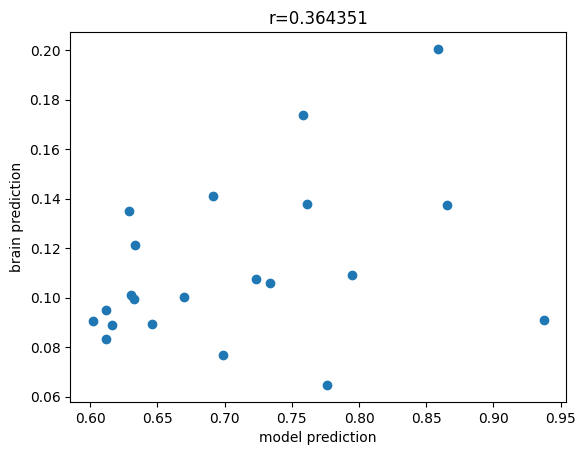

In [19]:
value=0.6
ind4=np.where(np.asarray(a1)>value)[-1]
print(len(ind4))
a1=np.asarray(a1)
a2=np.asarray(a2)
r=scipy.stats.pearsonr(a1[ind4],a2[ind4])[0]
plt.scatter(a1[ind4],a2[ind4])
plt.title(f"r=%f" % r)

print(scipy.stats.pearsonr(a1[ind4],a2[ind4]))
print(len(ind4))
plt.xlabel('model prediction')
plt.ylabel('brain prediction')

# plt.savefig('/scratch/gpfs/arnab/sentence_encoding/results/t_n_calculation/layer_2.png',dpi=600)
plt.show()

In [297]:
# df.loc[~df.adjusted_onset.isnull() & (df.token_idx==0)] # and df.token_idx==1
# df_head=df_head.reset_index(drop=True)
a_10=df_head.loc[(df_head.layer==40) & (df_head.context==10)].head_kl.values
a_50=df_head.loc[(df_head.layer==40) & (df_head.context==50)].head_kl.values

# b_10=df_head.loc[(df_head.layer==48) & (df_head.context==10)].cross_entropy.values
# b_50=df_head.loc[(df_head.layer==48) & (df_head.context==50)].cross_entropy.values

In [299]:
a_50-a_10

array([0.86283688, 0.33086592, 0.97741133, 0.7791785 , 0.77024711,
       0.81431765, 0.85223865, 1.04849871, 0.69671497, 0.84136732,
       0.73701386, 1.23810513, 0.92854832, 0.95423837, 0.69228689,
       0.89898524, 0.69707244, 0.37893621, 1.36219934, 0.69137481,
       0.66421495, 0.89527696, 1.02563463, 1.05109114, 0.94405067])

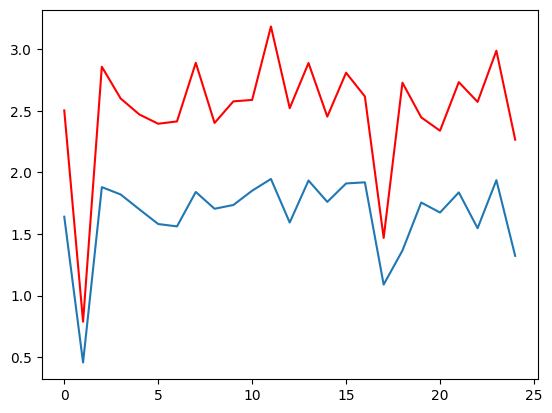

In [298]:
plt.plot(a_10)
plt.plot(a_50,'r')

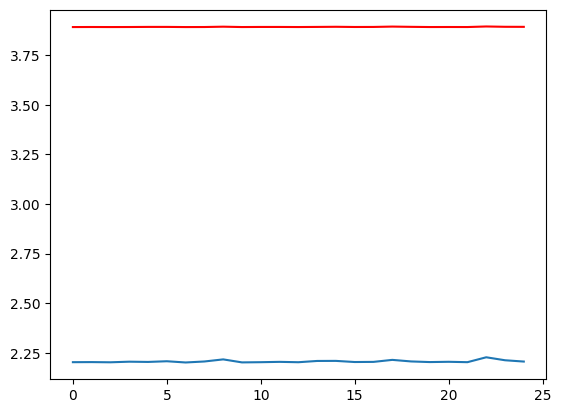

In [111]:
plt.plot(b_10)
plt.plot(b_50,'r')

In [113]:
sentence

986

-0.024597005975642534


(array([  4.,  23.,  71., 174., 258., 212., 155.,  68.,  17.,   5.]),
 array([-0.49857143, -0.40244898, -0.30632653, -0.21020408, -0.11408163,
        -0.01795918,  0.07816327,  0.17428571,  0.27040816,  0.36653061,
         0.46265306]),
 <BarContainer object of 10 artists>)

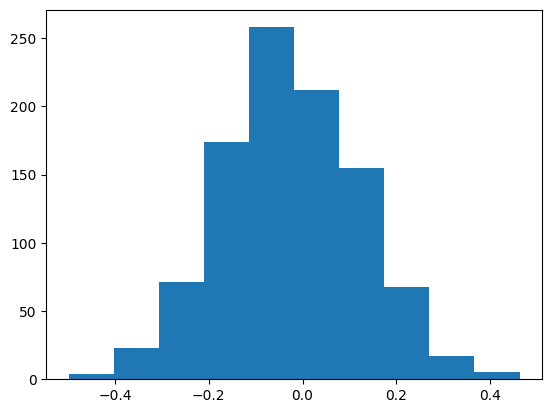

In [134]:
print(np.mean(spearman_corr_score))
plt.hist(spearman_corr_score)

-0.008137726341983042


(array([ 14.,  25., 100., 198., 247., 218., 112.,  53.,  17.,   3.]),
 array([-0.44096763, -0.34783403, -0.25470042, -0.16156682, -0.06843322,
         0.02470039,  0.11783399,  0.21096759,  0.3041012 ,  0.3972348 ,
         0.4903684 ]),
 <BarContainer object of 10 artists>)

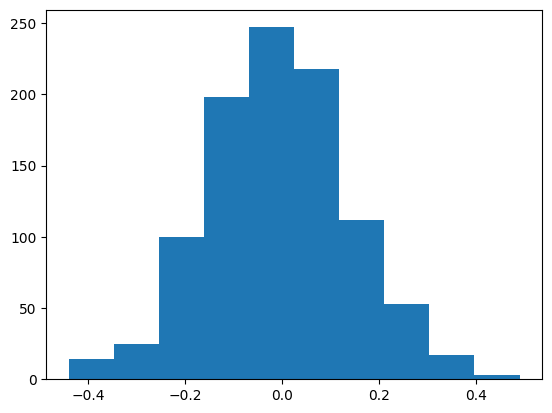

In [115]:
print(np.mean(pearson_corr_score))
plt.hist(pearson_corr_score)

(array([326., 385., 164.,  71.,  31.,  31.,  10.,   5.,   1.,   3.]),
 array([0.03837594, 0.44142439, 0.84447284, 1.24752129, 1.65056974,
        2.0536182 , 2.45666665, 2.8597151 , 3.26276355, 3.665812  ,
        4.06886045]),
 <BarContainer object of 10 artists>)

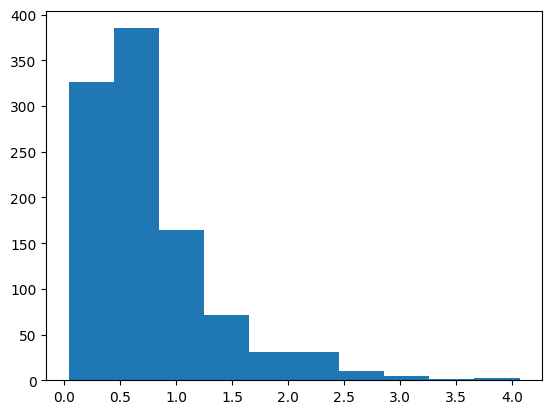

In [15]:
plt.hist(kl)

In [6]:
path_ken1="/scratch/gpfs/arnab/247-pickling/results/podcast/661/embeddings//"
model_size='gpt2-xl'
path_ken=path_ken1+model_size+'/full/'
path_emb=path_ken+'cnxt_0050/layer_25/'
os.chdir(path_emb)

emb_file='NY661_111_Part1_conversation1.pkl'

pickle_file = open(emb_file, "rb")
objects = []

i=0

while True:
    print('i',i)
    try:

        objects.append(pickle.load(pickle_file))

    except EOFError:

        break

pickle_file.close()

a=objects[0]

df_emb=pd.DataFrame(a)
df_bert=df_emb.iloc[index]
w=(df_bert.embeddings.values)
# type(w[0])
# np.shape(w)
emb=np.zeros((len(w),np.shape(w[0])[0]))
for i in range(len(w)):
    emb[i,:]=w[i]
    
print(np.shape(emb))

pca = PCA(n_components=50)
emb=emb- np.mean(emb, axis=0)
word_embeddings=pca.fit_transform(emb)

# path="/scratch/gpfs/arnab/Encoding/different_size/"
# os.chdir(path)
# filename=model_size+'.mat'
# savemat(filename,{'onset':onset,'embeddings':emb})
# del emb

i 0
i 0


NameError: name 'index' is not defined

In [7]:
df_emb.columns

Index(['topk_pred', 'topk_pred_prob', 'true_pred_prob', 'true_pred_rank',
       'surprise', 'entropy', 'embeddings'],
      dtype='object')

In [13]:
for k in range(47):

    path1='/scratch/gpfs/arnab/sentence_encoding/results/gpt2-xl/'
    new='layer_'+str(k)
    path=path1+new

    c11='/context_50'
    c22='/context_10'

    c1=path+c11
    c2=path+c22
    
    os.mkdir(path)

    os.mkdir(c1)
    os.mkdir(c2)


In [5]:
path

'/scratch/gpfs/arnab/sentence_encoding/results/gpt2-xl/layer_45'

In [18]:
layer=47
context=50
path1='/scratch/gpfs/arnab/sentence_encoding/results/gpt2-xl/' 
path=path1+'layer_'+str(layer)+'/context_'+str(context)+'/'


# path='/scratch/gpfs/arnab/sentence_encoding/results/gpt2-xl/layer_48/'    
os.chdir(path)

In [33]:
list(range(1,3,1))

[1, 2]

In [90]:
mu, sigma = 10, 0.15 # mean and standard deviation
epsilon = 0.000001
s1 = np.random.normal(mu, sigma, 50000)
# s1=s1/np.sum(s1)

s2 = np.random.normal(mu, sigma+60, 50000)
# s2=s2/np.sum(s2)
print(kl_divergence(s1,s2))


nan


/tmp/ipykernel_1056163/3149447335.py:40: RuntimeWarning: invalid value encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


In [92]:
a=np.histogram(s1,bins=500)[0]
a=a/a.sum()

b=np.histogram(s2,bins=500)[0]
b=b/b.sum()
# print(kl_divergence(a,b))

ind=np.where(a==0)
a=np.delete(a, ind)
b=np.delete(b, ind)

ind=np.where(b==0)
a=np.delete(a, ind)
b=np.delete(b, ind)

a=a/a.sum()
b=b/b.sum()

print(kl_divergence(a,b))

0.1513926171700081


In [93]:
len(a)

369

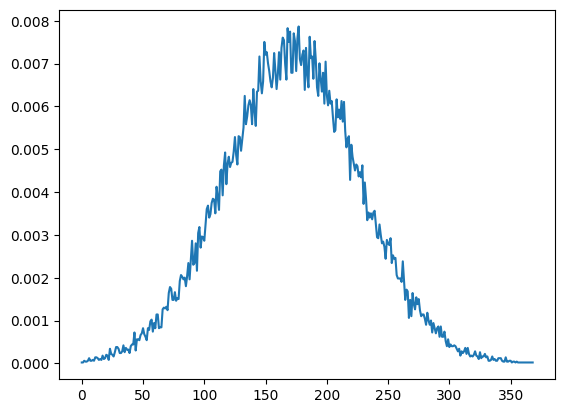

In [94]:
plt.plot(a)

In [68]:
import random 
df=pd.DataFrame()
np.random.seed(500)
contexts=[10]
layers=list(range(48,49,1))
heads=[1,3,8,10,11,17,21,22,24,25]###np.arange(1,26)

###[1,3,8,10,11,17,21,22,24,25] for layer 48 seed 500

##[1,3,4,10,14,16,22,] 
start=4000
k=0
# loss = torch.nn.CrossEntropyLoss()
onsets, words, index=load_word()
Y=load_ecog(onsets)

for layer in layers:
    print('layer:',layer)
    for context in contexts: 
        
        word_embeddings=load_embeddings(index, context, layer)
        
        sentence,sliding_error,original_error,corr=sliding_window(start, context,Y,word_embeddings,words)

        print('context:',context)

       
        
        
        # head_kl1=[]
        # head_cross_entropy1=[]

        a1=[]
        a2=[]
        a3=[]
        a4=[]
        
        for head in heads:
            name='attention_gpt2-xl_layer_'+str(layer)+'_head_'+str(head)+'_context_'+str(context)+'.pkl'
            
            pickle_file_path='/scratch/gpfs/arnab/sentence_encoding/results/gpt2-xl/layer_'+str(layer)+'/context_'+str(context)+'/'+name
            df_attn=load_pickle(pickle_file_path)
            attn=df_attn['attention_mask']
            
            spearman_corr_score=[]
            pearson_corr_score=[]
            output=[]
            kl=[]
            wassertain=[]
            
            
            
            corr_error_ecog=[]
            corr_error_random=[]

            attn_error=[]
            random_error=[]
            corr_error_ecog=[]
            corr_error_random=[]
            # elec=0,4,6,7
            elec=8
            # elec=[3, 4, 5, 7, 9, 12, 13, 14, 16, 17, 18, 26, 30, 34, 36, 37, 39, 40, 41, 42]
            elec=[ 0,  2, 10, 13, 15, 16, 17, 19, 20, 28, 29, 33, 34, 36, 41, 42]
            # elec=list(range(0,43,1))
            
            for sentence in range(len(attn)):
                x1=attn[sentence] ##attention mask
                # x1=softmax(x1)
                x1=x1/np.sum(x1)

                secondMax,MaxVal = sorted(x1)[-2:]
                index_max = np.where(x1==MaxVal)
                index_secondMax = np.where(x1==secondMax)

                random=np.random.randint(0,context-1,size=1)

                attn_error1=[]
                random_error1=[]
      
                for elec1 in  elec:#range(1):#  range(np.shape(Y)[1]):
                
                    # x2 = original_error[sentence].mean(axis=1)  ##average of all the electrodes  
                    x2 = original_error[sentence][:,elec1]  ##selected electrode
                    x2=x2/x2[-1]

                    x2=np.where(x2>5,5,x2)
    
                    bb=x2[index_max] #+x2[index_secondMax]/2
                    bb=bb #/x2[-1]
    
                    x3=corr[sentence]
    
                    attn_error1.append(bb)
                    random_error1.append(x2[random].mean())
                    # corr_error_random.append(x3[random].mean())
                    # corr_error_ecog.append(x3[index_max])

                attn_error.append(np.mean(attn_error1))
                random_error.append(np.mean(random_error1))

                df.loc[k,'layer']=layer
                df.loc[k,'head']=head
                df.loc[k,'error']=np.mean(attn_error1)
                df.loc[k,'context']='attn'

                k=k+1

                df.loc[k,'layer']=layer
                df.loc[k,'head']=head
                df.loc[k,'error']=np.mean(random_error1)
                df.loc[k,'context']='random'

                k=k+1
            
            # print('head:',head)
            # print('attn_error:',np.mean(attn_error))
            # print('random_error:',np.mean(random_error))

            a1.append(np.mean(attn_error))
            a2.append(np.mean(random_error))
            # a3.append(np.mean(corr_error_ecog))
            # a4.append(np.mean(corr_error_random))
            print('head:',head)
            print(np.mean(attn_error))            
            print(np.mean(random_error))
            # print(np.mean(a3))
            # print(np.mean(a4))

            
                                       
        
        
            
        # print(np.mean(pearson_corr_score))
        # print(np.mean(spearman_corr_score))
        
            
            # print(np.corrcoef(a1,a2)[0,1])
            # print(stats.spearmanr(a1, a2).statistic)
            # head_cross_entropy1.append(np.mean(output))  
            # # print(np.std(output))  
            # head_kl1.append(np.mean(kl))
        
            # df_head.loc[k,'layer']=layer
            # df_head.loc[k,'head_kl']=np.mean(kl)
            # # df_head.loc[k,'cross_entropy']=np.mean(output)
            # df_head.loc[k,'context']=context
            # # df_head.loc[k,'wassertain']=np.mean(wassertain)
            # k=k+
# ind=[3, 4, 5, 7, 9, 12, 13, 14, 16, 17, 18, 26, 30, 34, 36, 37, 39, 40, 41, 42]
# df=pd.DataFrame()
# df['attn']=attn_error1
# df['random']=random_error1
# df['compare']= np.where((df['attn'] < df['random']), 1, 0)
# df['compare'].sum()

print(np.mean(a1))
print(np.mean(a2))    

subject: 717
layer: 48
context: 10
head: 1
2.1167402690146084
2.1202675191736087
head: 3
2.1257517156661314
2.130743781848964
head: 8
2.1307257766399847
2.1399874644743586
head: 10
2.1238073449898853
2.12117877504342
head: 11
2.1200720640748916
2.1119960127167916
head: 17
2.117233388207539
2.1039047621209073
head: 21
2.1167387239521833
2.1310085195571244
head: 22
2.1162932705758646
2.136834101702667
head: 24
2.058175376008366
2.133848413832867
head: 25
2.095109899722347
2.159137833331011
2.11206478288518
2.1288907183801724


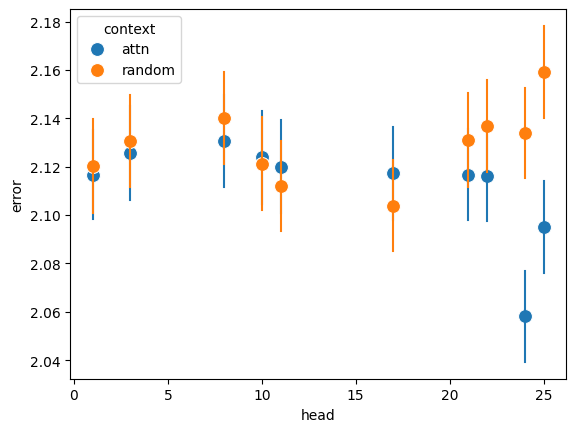

In [69]:
snsplt = sns.lineplot(
    data=df, #loc[df_head.context==10],
    x="head",
    y="error",
    hue="context",
    marker="o",
    markersize=10,
    # alpha = 0.5,
    
    linestyle='',
    err_style='bars',
    errorbar="se",)
    # hue_order=["gpt2","llama2","opt","gpt-neo","llama2-q","opt-q"]
    # hue_order=["gpt2","llama2-q","opt-q","gpt-neo"]




fig = snsplt.get_figure()
fig.savefig("/scratch/gpfs/arnab/sentence_encoding/head_error_layer_48.png",dpi=600) 
plt.show()

In [322]:
df

,layer,head,error,context
0,1.0,1.0,1514.366890,attn
1,1.0,1.0,2879.981297,random
2,1.0,1.0,2588.604420,attn
3,1.0,1.0,5176.912065,random
4,1.0,1.0,5393.616410,attn
...,...,...,...,...
16427,4.0,2.0,2606.519158,random
16428,4.0,2.0,2028.973439,attn
16429,4.0,2.0,2085.901172,random
16430,4.0,2.0,2294.357274,attn


In [71]:
df=pd.DataFrame()
df['attn']=attn_error
df['random']=random_error
df['compare']= np.where((df['attn'] < df['random']), 1, 0)
# df.loc[df['compare']==1].index
df['compare'].sum()

449

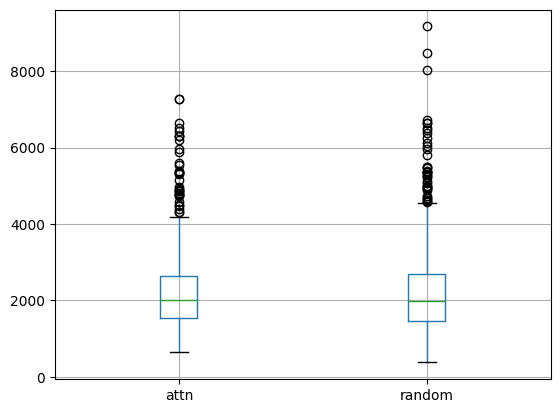

In [35]:
boxplot = df.boxplot(column=['attn', 'random'])

In [20]:
df_corr=pd.DataFrame()
contexts=[10]
layers=[48]#list(range(1,48,1))
heads=np.arange(1,26)

#### for layer 48, heads [1,3,4,10,14,22,]

start=4000
k=0
# loss = torch.nn.CrossEntropyLoss()
onsets, words, index=load_word()
Y=load_ecog(onsets)

for layer in layers:
    print('layer:',layer)
    for context in contexts: 
        
        word_embeddings=load_embeddings(index, context, layer)
        
        sentence,sliding_error,original_error,corr=sliding_window(start, context,Y,word_embeddings,words)

        print('context:',context)
        
       

        # head_kl1=[]
        # head_cross_entropy1=[]

        
        for head in heads:
            name='attention_gpt2-xl_layer_'+str(layer)+'_head_'+str(head)+'_context_'+str(context)+'.pkl'
            
            pickle_file_path='/scratch/gpfs/arnab/sentence_encoding/results/gpt2-xl/layer_'+str(layer)+'/context_'+str(context)+'/'+name
            df_attn=load_pickle(pickle_file_path)
            attn=df_attn['attention_mask']
            
            a1=[]
            a2=[]
            
            
            elec=36
            
            for sentence in range(len(attn)):
                x1=attn[sentence] ##attention mask
                # x1=softmax(x1)
                x1=x1/np.sum(x1)

            
                a1.extend(x1)
                
                x2 = sliding_error[sentence].mean(axis=1)  ##average of all the electrodes  
                # x2 = sliding_error[sentence][:,elec]  ##selected electrode
            
                a2.extend(x2)   

            ind4=np.where(np.asarray(a1)>0.6)[-1]
            a1=np.asarray(a1)
            a2=np.asarray(a2)

            if len(ind4)>20:
                  
                df_corr.loc[k,'layer']=layer
                df_corr.loc[k,'head']=head
                df_corr.loc[k,'corr']=scipy.stats.pearsonr(a1[ind4],a2[ind4])[0]
                df_corr.loc[k,'context']=context
                df_corr.loc[k,'len']=len(ind4)
                # df_head.loc[k,'wassertain']=np.mean(wassertain)
                del a1
                del a2
                del ind4
                k=k+1
                



subject: 717
layer: 48
context: 10


In [21]:
df_corr 

,layer,head,corr,context,len
0,48.0,1.0,0.125414,10.0,28.0
1,48.0,2.0,-0.083849,10.0,36.0
2,48.0,3.0,0.213878,10.0,21.0
3,48.0,4.0,0.138542,10.0,56.0
4,48.0,5.0,-0.137515,10.0,77.0
5,48.0,6.0,0.050103,10.0,164.0
6,48.0,8.0,0.012162,10.0,99.0
7,48.0,9.0,-0.010427,10.0,442.0
8,48.0,10.0,0.426127,10.0,24.0
9,48.0,11.0,-0.025378,10.0,44.0


In [99]:
x2[index_max]

array([269.85092636])

In [97]:
x2

array([3.31466321e+03, 4.42245902e+03, 3.42042611e-01, 3.12247464e+03,
       6.35490939e+02, 3.58846180e+02, 5.72367259e+02, 2.69850926e+02,
       3.09309095e+03, 3.19568560e+03])

## Plotting

In [2]:
data=loadmat('/scratch/gpfs/arnab/sentence_encoding/results/t_n_calculation/t_5_calculation.mat')
final_corr=data['real_sentence_final_corr']
lags=np.squeeze(data['lags'])
subjects=data['subjects']
elec_num=np.squeeze(data['elec_num'])
corr_sliding_sentence=data['sliding_sentence_t_n_717']
             

In [173]:
elec_num

array([15, 43, 19,  8, 40, 12, 16, 31])

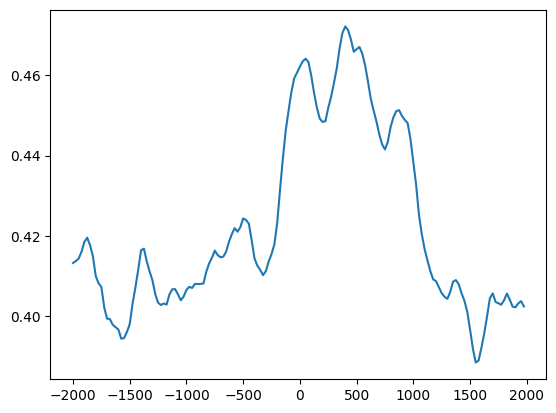

In [93]:
sub=1
a1=final_corr[sub,0,:,:elec_num[sub]].mean(axis=1)
plt.plot(lags,a1)
plt.show()

In [146]:
np.shape(corr_sliding_sentence)

(5, 160, 43)

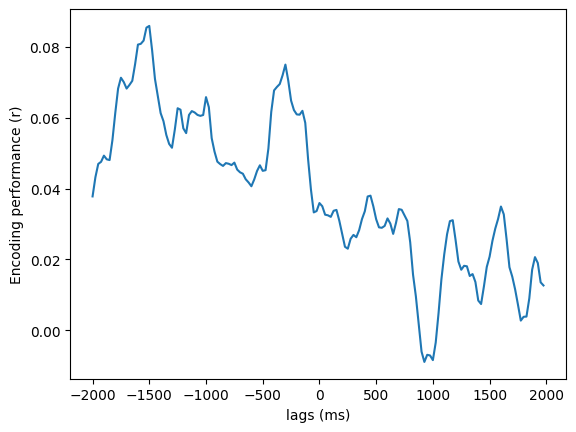

In [8]:
ind3=[ 0,  2, 10, 13, 15, 16, 17, 19, 20, 28, 29, 33, 34, 36, 41, 42]
a1=(corr_sliding_sentence[4,:,ind3]).T
a1=a1.mean(axis=1)
# np.shape(a1)
# a1[ind3].mean()
plt.plot(lags,a1)
plt.xlabel('lags (ms)')
plt.ylabel('Encoding performance (r)')

plt.savefig('/scratch/gpfs/arnab/sentence_encoding/results/t_n_calculation/t_n_5.png',dpi=600)
plt.show()

In [148]:
a1=final_corr[0,0,:,:]
np.shape(a1)

(160, 43)

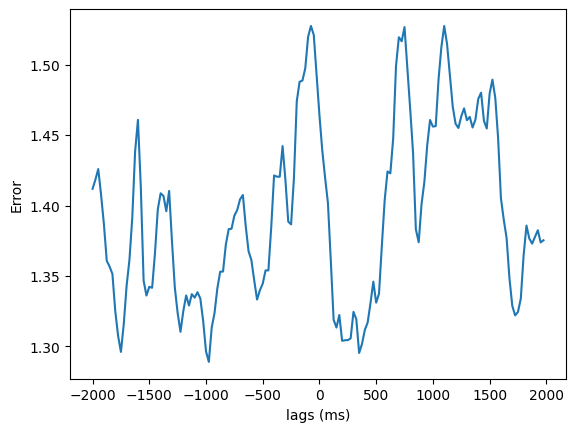

In [106]:
data=loadmat('/scratch/gpfs/arnab/sentence_encoding/results/t_n_calculation/t_5_mse.mat')
mse=data['t_5_mse']
lags=np.squeeze(data['lags'])

plt.plot(lags,mse[:,1])
plt.xlabel('lags (ms)')
plt.ylabel('Error')
plt.show()

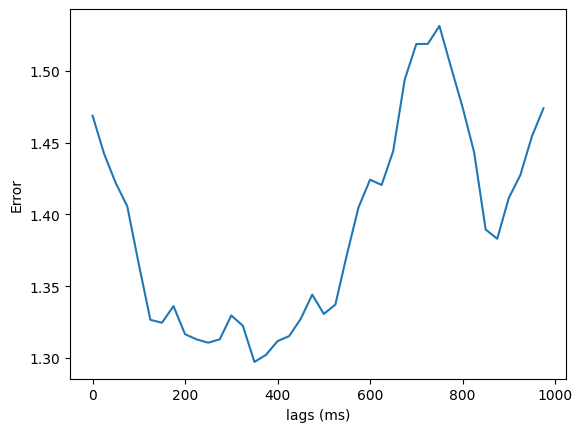

In [105]:
data=loadmat('/scratch/gpfs/arnab/sentence_encoding/results/t_n_calculation/t_5_mse_lag_0_1000.mat')
mse=data['t_5_mse']
lags=np.squeeze(data['lags'])

plt.plot(lags,mse[:,1])
plt.xlabel('lags (ms)')
plt.ylabel('Error')
plt.show()

In [66]:
lags

array([[    0,   400, -2000]])